### Plot the magnetization of a halbach array, and add the magnetization of shimming sphere

lens ap: 0.04000000000000001


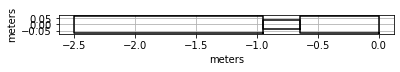

In [1]:
import numpy as np
import scipy.interpolate as spi
from SwarmTracerClass import SwarmTracer
import warnings
from elementPT import HalbachLensSim
from ParticleClass import Swarm,Particle
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
from helperTools import *
from nozzleSimulationFunctions import get_FWHM,Interpolater

LObject=72.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,)
magnetWidth=(.0254,)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe




PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector',fieldDensityMultiplier=1.0,standardMagnetErrors=False,jitterAmp=1e-3)
PTL.add_Drift(LObject,ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,apFrac=.8,magnetWidth=magnetWidth)
# PTL.add_Lens_Ideal(LLens-4*rpLens[0],1.0,rpLens[0])
PTL.add_Drift(LImage*2,ap=.07)
# assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()
lensIndex=1
assert type(PTL.elList[lensIndex])==HalbachLensSim
assert abs((PTL.elList[lensIndex].L-PTL.elList[lensIndex].Lm)/2-LFringe)<1e-9
xMin=abs(PTL.elList[-1].r1[0])
xMax=abs(PTL.elList[-1].r2[0])
print('lens ap:',PTL.elList[lensIndex].ap)
PTL.show_Lattice()


In [5]:
lens=PTL.elList[1]
L,rp=lens.L,lens.rp
shifty=500e-6
shiftz=500e-6
qTest1=np.asarray([L/2.0,rp/2.0,rp/2.0])
qTest2=qTest1.copy()
qTest1[1]-=shifty
qTest1[2]-=shiftz

print(lens.force(qTest1))
lens.perturb_Element(500e-6,shiftz,0.0,0.0)
print(lens.force(qTest2))
lens.perturb_Element(0.0,0.0,0.0,0.0)

[ 7.27702286e-08 -1.15600754e+04 -1.15085503e+04]
[ 7.27702286e-08 -1.15600754e+04 -1.15085503e+04]


In [ ]:
plt.plot(pointsList,results)
plt.show()
results

NameError: name 'mSymFunc' is not defined

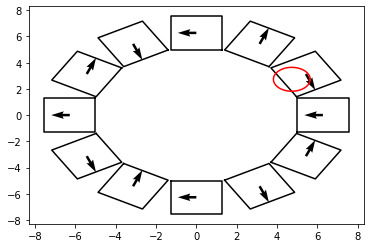

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.affinity import rotate
from HalbachLensClass import Layer

rp=(.05,)
width=.0254

thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # location of 12 magnets
thetaArr=thetaArr.reshape(-1,len(rp)).T
phiArr = np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization
phiArr=phiArr.reshape(-1,len(rp)).T
quiverData=[]
for r,r_phi,r_theta in zip(rp,phiArr,thetaArr):
    for phi,theta in zip(r_phi,r_theta):
        x,y=(r+width/2)*np.cos(theta)*1e2,(r+width/2)*np.sin(theta)*1e2
        quiverData.append([x,y,np.cos(phi),np.sin(phi)])
quiverData=np.asarray(quiverData)

squareCoords=np.asarray([(rp[0],-width/2),(rp[0]+width,-width/2),(rp[0]+width,width/2),(rp[0],width/2)])*1e2
squareOriginal=Polygon(squareCoords)
angleArr=np.linspace(0,np.pi*2,13)[:-1]
for angle in angleArr[:]:
    square=rotate(squareOriginal,angle,origin=(0,0),use_radians=True)
    plt.plot(*square.exterior.xy,c='black')





plt.quiver(*quiverData.T,label='Magnets')
rShim=.0546
phi0=np.pi/6
radius=.911
psi0=5.89
point0=Point([1e2*rShim,0])
phiArr=phi0+np.linspace(0.0,2*np.pi,7)[1:]
phiArr=np.flip(phiArr)

assert abs(abs(phiArr[1]-phiArr[0])-np.pi/3)<1e-6
psi=psi0
m=np.asarray([np.cos(psi),np.sin(psi)])
quiverData=[]
i=0
booList=[False,True]*5
for phi in phiArr[:3]:
    point=rotate(point0,phi,origin=(0.0,0.0),use_radians=True)
    plt.plot(*point.buffer(radius).exterior.xy,c='r')
    x,y=1e2*rShim*np.cos(phi),1e2*rShim*np.sin(phi)
    mSym=mSymFunc(m,factors=i,flipDipolexy=booList[i])
    quiverData.append([x,y,*mSym])
    i+=1
quiverData=np.asarray(quiverData)
plt.quiver(*quiverData.T,color='r',label='shims')# plt.quiver(quiverData[:,0],quiverData[:,1],quiverData[:,2],quiverData[:,3],color='r',label='shims')

layer=Layer(0.0,width,.5,rp)
xArr=np.linspace(-rp[0],rp[0],50)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
BVec=layer.B(coords)
B=np.linalg.norm(BVec,axis=1)
B[np.linalg.norm(coords,axis=1)>rp[0]*.99]=np.nan
B=B.reshape(len(xArr),len(xArr))
plt.imshow(B,extent=[min(xArr)*100.0,max(xArr)*100.0]*2)
# BxGrid=BVec[:,0].reshape(len(xArr),len(xArr))
# ByGrid=BVec[:,1].reshape(len(xArr),len(xArr))
# plt.streamplot(xArr*1e2,xArr*1e2,BxGrid,ByGrid,density=.8)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend()
plt.xlabel('cm')
plt.ylabel('cm')
plt.title('Run1 magnetization direction of \n lens magnets and shims')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [ ]:
booList

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phi0=0*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
phiArr=np.arange(0, 6) * 4 * np.pi / 3
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    if rotations%2==1:
        mu = np.tan(rotations*rotationAngle/2)
        M_uc = np.asarray([[1 - mu ** 2, 2 * mu], [2 * mu, mu ** 2 - 1]]) * 1 / (1 + mu ** 2)  # reflection matrix
        mSym=M_uc@m
    else:
        M_Angle=rotationAngle*rotations
        MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
        mSym=MRot@m
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phi0=.5*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    M_Angle=rotationAngle*rotations
    MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
    mSym=MRot@m
    mSym*=(-1)**rotations
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [3]:
from asyncDE import solve_Async
from helperTools import *
def func(X):
    return np.sin(X[0])
solve_Async(func,[(0,1.0)],10,saveData='dummy',timeOut_Seconds=100)

------ITERATIONS:  10
POPULATION VARIABILITY: [0.2795085]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.02190996])
cost: 0.0219082086845373
------ITERATIONS:  20
POPULATION VARIABILITY: [0.28688691]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
------ITERATIONS:  30
POPULATION VARIABILITY: [0.155358]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
------ITERATIONS:  40
POPULATION VARIABILITY: [0.06905436]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
finished with total evals:  46


In [ ]:
import numpy as np

a=np.array([0.22335083, 0.05468504, 0.01778291, 1.86398975, 5.89642321])
b=np.array([0.22336635, 0.05398954, 0.01994955, 2.174386  , 5.1246072 ])
c=np.array([0.22336904, 0.05486956, 0.01967456, 1.16595304, 4.66104557])
d=np.array([0.22232782 ,0.05411236 ,0.01467107 ,1.69968186 ,5.40909307])
e=np.array([0.2228413  ,0.05462561 ,0.01132046 ,1.28740702 ,5.31414559])
arr=np.column_stack((a,b,c,d,e))
np.std(arr,axis=1),np.mean(arr,axis=1)

In [ ]:
#locked phi,locked theta, variable radius
a=np.array([0.2425    , 0.06891085, 0.02262274, 3.05662444, 0.02194268,
            0.06575895, 0.04839916, 5.17701814, 0.0254,.08078    ])
e=np.zeros(len(a))*np.nan
e[0]=.23
e[-1]=1.0

rowLabels=['L', 'r', 'deltaZ','psi','radius','r', 'deltaZ','psi','radius','cost']
colLabels=['param,SI','run1','baseline lens']
cellText=[]




cellText=[rowLabels,arrToStr(a),arrToStr(e)]
cellText=list(zip(*cellText))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.table(cellText=cellText,cellLoc ='center',loc ='upper left',colLabels=colLabels)
plt.savefig('poop',dpi=100)
plt.show()

In [ ]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254

DNAList=[]
phaseList=[0.0,0*np.pi/24]
print(phaseList)
for phase in phaseList:
    dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
    DNAList.append(dict)
lens=GeneticLens(DNAList)
xArr=np.linspace(-rp*.9,rp*.9,100)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
image=vals.reshape(len(xArr),len(xArr))
plt.imshow(image)
plt.show()

In [ ]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254*10
def plot_Field(phaseList):
    DNAList=[]
    for phase in phaseList:
        dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
        DNAList.append(dict)
    lens=GeneticLens(DNAList)
    xArr=np.linspace(-rp*.9,rp*.9,100)
    coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
    vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
    vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
    image=vals.reshape(len(xArr),len(xArr))
    print(np.nansum(image))
    plt.imshow(image)
    plt.show()
plot_Field([0.0]*2)
plot_Field([np.pi/12]*2)
plot_Field([0.0,np.pi/6])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt("data")

In [ ]:
data

In [ ]:
plt.scatter(data[:,0],data[:,3])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from HalbachLensClass import Layer,SegmentedBenderHalbach
import numpy as np
from parallel_Gradient_Descent import gradient_Descent
from scipy.optimize import curve_fit
import multiprocess as mp
import time
rp0,rb0,Lm0,extraSpace0=.01,1.0,.0254/2.0,0.0
magnetWidth = rp0 * np.tan(2 * np.pi / 24) * 2
yokeWidth=magnetWidth
Lseg = Lm0 + extraSpace0 * 2
ucAng=np.arctan(Lseg/(2*(rb0-rp0-yokeWidth)))

In [ ]:

# numPointsGridEdge=500
# xArr=np.linspace(-rp0,rp0,numPointsGridEdge)
# coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
# def makge_And_Trim_Vals(lens,rp):
#     vals=np.asarray([np.linalg.norm(lens.B(np.asarray([coord]))) for coord in coords])
#     vals[np.linalg.norm(coords,axis=1)>=rp]=np.nan
#     vals[np.linalg.norm(coords,axis=1)<=.1*rp]=np.nan
#     return vals
# def nominal_Values(rp):
#     lens=Layer(0.0,.025,1.0,.05)
#     return makge_And_Trim_Vals(lens,rp)
# def error_Values(rp,amp=1.0):
#     np.random.seed(int(time.time()*1e6)%10_000)
#     rpMagnetShift=amp*.01*rp*(np.random.random_sample(12)-.5)
#     M_ShiftRelative=amp*.01*(np.random.random_sample(12)-.5)
#     thetaShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     phiShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     lens=Layer(0.0,.025,1.0,.05,rMagnetShift=rpMagnetShift,M_ShiftRelative=M_ShiftRelative,thetaShift=thetaShift,phiShift=phiShift)
#     return makge_And_Trim_Vals(lens,rp)
# valsNominal=nominal_Values(rp0)
# imageNominal=valsNominal.reshape((int(np.sqrt(len(valsNominal))),)*2)
# plt.imshow(imageNominal)
# plt.show()

In [ ]:
import multiprocess as mp
numRuns=100
with mp.Pool(8) as pool:
    errorResults=np.asarray(pool.map(error_Values,[rp0]*numRuns))
valsErrorRMS=np.std(errorResults,axis=0)
valsRelativeError=(valsErrorRMS/valsNominal)
imageRelativeError=valsRelativeError.reshape((int(np.sqrt(len(valsNominal))),)*2)
plt.imshow(imageRelativeError)
plt.show()

In [ ]:
coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
valsNanTrimmed=valsRelativeError[~np.isnan(valsRelativeError)]
thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
thetaArr[thetaArr<0.0]+=2*np.pi
#
numBins=100
thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
errorThetaVals=errorThetaVals/thetaFrequency

binCenter=bins[:-1]+(bins[1]-bins[0])/2

plt.plot(binCenter,errorThetaVals)
plt.ylabel('mean relative RMS deviation')
plt.xlabel('theta (radians)')
plt.show()

In [ ]:
# plt.semilogy(thetaArr,valsRelativeError,linewidth=0.0,marker='o',alpha=.1)
# plt.show()

for i in range(len(errorResults)):
    coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
    valsNanTrimmed=errorResults[i][~np.isnan(valsRelativeError)]-valsNominal[~np.isnan(valsRelativeError)]
    thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
    thetaArr[thetaArr<0.0]+=2*np.pi
    #
    numBins=100
    thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
    errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
    errorThetaVals=errorThetaVals/thetaFrequency

    binCenter=bins[:-1]+(bins[1]-bins[0])/2

    # plt.plot(binCenter,errorThetaVals)
    # plt.show()

In [ ]:
# plot radial dependence
rArr=np.sqrt(coords[:,0]**2+coords[:,1]**2)
plt.scatter(rArr,valsRelativeError,alpha=.01)
plt.show()

In [ ]:
#where is the field the smallest in a bender, ie where is the center?

numLens=41
bender=SegmentedBenderHalbach(rp0,rb0,ucAng,Lm0,numLenses=numLens,positiveAngleMagnetsOnly=False)
thetaMaxGeom=np.arctan(Lm0*(numLens/2)/rb0)
thetaMax=Lm0/rb0
assert thetaMax<thetaMaxGeom/5.0 # assert small segment of total bend

In [ ]:

def field_Val(deltaR,theta):
    if isinstance(deltaR,(tuple,list,np.ndarray)):
        deltaR=deltaR[0]
    r=rb0+deltaR
    x,y,z=np.cos(theta)*r,0.0,np.sin(theta)*r
    val=bender.BNorm(np.array([x,y,z]))
    return val
def find_rZero(theta):
    minFunc=lambda x: field_Val(x,theta)
    deltaR_Zero=gradient_Descent(minFunc,[0.0],30e-6,50,parallel=False,disp=False,gradStepSize=1e-6)[0][0]
    rZero=rb0+deltaR_Zero
    return rZero
numPoints=50
thetaArr=np.linspace(-1.0,1.0,numPoints)*thetaMax
with mp.Pool() as pool:
    rZeroArr=np.asarray(pool.map(find_rZero,thetaArr))
xZeroArr=np.array([r*np.cos(theta) for r,theta in zip(rZeroArr,thetaArr)])
zZeroArr=np.array([r*np.sin(theta) for r,theta in zip(rZeroArr,thetaArr)])

In [ ]:
deltaRArr=(rZeroArr-rb0)/1e-6

plt.plot(thetaArr,deltaRArr)
plt.scatter(thetaArr,deltaRArr)
thetaLm=np.arctan(Lm0/rb0)
plt.axvline(x=thetaLm/2.0,c='r')
plt.axvline(x=-thetaLm/2.0,c='r')
# plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#fit sines to the rZero depndence as a function of thea
y=deltaRArr.copy()
# y-=(y.max()+y.min())/2.0
# y/=y.max()
# y-=np.mean(y)
# y/=np.max(y)
a0=np.trapz(y*np.cos(0thetaArr),x=thetaArr)
plt.plot(thetaArr,y)
plt.show()
a0

In [ ]:
numPoints=100
xArr=np.linspace(rb0-(1-np.cos(thetaMax))*rb0-rp0,rp0+rb0,numPoints)
zArr=np.linspace(-1.0,1.0,numPoints)*thetaMax*rb0
coords=np.array(np.meshgrid(xArr,0.0,zArr)).T.reshape(-1,3)
vals=bender.BNorm(coords)
image=np.flip(vals.reshape(numPoints,numPoints),axis=0)
xImage=np.flip(coords[:,0].reshape(numPoints,numPoints),axis=0)
for rowX,rowVal in zip(xImage,image):
    rowX[np.nanargmin(rowVal)]=np.nan
    # print(np.min(rowVal))
plt.imshow(xImage,extent=[xArr.min(),xArr.max(),zArr.min(),zArr.max()])
plt.plot(xZeroArr,zZeroArr,c='r')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import time
from constants import MAGNETIC_PERMEABILITY
import numpy as np
from numpy.linalg import norm
from HalbachLensClass import magpy_Prism,solve_And_Update_Magnetization_Interactions,HalbachLens
from demag_functions import apply_demag
# %matplotlib inline


In [ ]:
from magpylib import Collection
lens=HalbachLens(.15,.0254,.05,applyMethodOfMoments=False,subdivide=False)
BoxList=[p._magnet._magnet for p in lens.layerList[0].RectangularPrismsList]
col=Collection(*BoxList)
apply_demag(col,np.ones(len(BoxList))*.05)
for layer in lens.layerList:
    for prism in layer.RectangularPrismsList:
        #print(1.0-np.linalg.norm(prism._magnet.get_M_Vector()) /np.linalg.norm(prism.M) )
        print(prism._magnet.get_M_Vector()[1])

In [ ]:
lens=HalbachLens(.15,.0254,.05,applyMethodOfMoments=True,subdivide=False)
BoxList=[p._magnet._magnet for p in lens.layerList[0].RectangularPrismsList]
for layer in lens.layerList:
    for prism in layer.RectangularPrismsList:
        #print(1.0-np.linalg.norm(prism._magnet.get_M_Vector()) /np.linalg.norm(prism.M) )
        print(prism._magnet.get_M_Vector()[1])

In [ ]:
0.025999907856928517-.022682154944148047,0.02446192789984869-0.02093190261679334

In [ ]:
import magpylib as magpy
from scipy.spatial.transform import Rotation
import numpy as np
R=Rotation.from_rotvec([0.0,0.0,3.14])


M=1.0
w=1.0
L=2.0
r0=5.0
x0,y0,z0=0.0,0.0,0.0
phase=np.pi/2
psi=.5
thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)+phase  # location of 12 magnets.
phiArr =phase+ np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization


c1 = magpy.Collection()
for theta,phi in zip(thetaArr,phiArr):
    x,y=r0*np.cos(theta),r0*np.sin(theta)
    R=Rotation.from_rotvec([0.0,0.0,phi])
    box=magpy.magnet.Box(magnetization=(M,0.0,0.0),dimension=(w,w,L),position=(x,y,0.0),orientation=R)
    box.move([x0,y0,z0])
    c1.add(box)
    # c.display()
c2 = magpy.Collection()
for theta,phi in zip(thetaArr,phiArr):
    x,y=r0*np.cos(theta),r0*np.sin(theta)
    R=Rotation.from_rotvec([0.0,0.0,phi])
    box=magpy.magnet.Box(magnetization=(M,0.0,0.0),dimension=(w,w,L),position=(x,y,5.0),orientation=R)
    box.move([x0,y0,z0])
    c2.add(box)
    # c.display()
c3 = magpy.Collection(c1,c2)
R=Rotation.from_rotvec([0.0,psi,0.0])
c3.rotate(R,anchor=0.0)
c3.display()

In [ ]:
class Layer:
    def __init__(self,magnetWidths,magnetLength):
        pass

In [ ]:
from scipy.spatial.transform import Rotation
halfAngMax=1*np.pi/180
x1Rand=halfAngMax*(2*(np.random.random_sample()-.5))
x2Rand=halfAngMax*(2*(np.random.random_sample()-.5))
X=[1.0,0.0,0.0]
r1=Rotation.from_rotvec([0,x1Rand,0])
r2=Rotation.from_rotvec([0,0,x2Rand])
r=r1*r2
r.as_matrix()@X